# Data Cleaning and Pre-processing

In [ ]:
import os
import pandas as pd
import numpy as np

def clean_csv_files(input_folder, output_folder, project_status_file):
    os.makedirs(output_folder, exist_ok=True)
    
    ps_df = pd.read_csv(project_status_file, keep_default_na=False, na_values=[], low_memory=False)

    columns_to_drop = [
        'issue_url', 'comment_url', 'id', 'issue_num',
        'title', 'user_login', 'user_id', 'user_name',
        'user_email', 'body', 'reactions'
    ]
    
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            
            df = pd.read_csv(file_path, keep_default_na=False, na_values=[], low_memory=False)

            df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
            
            # Convert created_at and updated_at to date format (YYYY-MM-DD) if they exist
            if 'created_at' in df.columns:
                df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date
            if 'updated_at' in df.columns:
                df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce').dt.date
            
            # Compute the difference in days between updated_at and created_at, including the end date.
            if 'created_at' in df.columns and 'updated_at' in df.columns:
                df['days_elapsed'] = (df['updated_at'] - df['created_at']).apply(
                    lambda x: x.days + 1 if pd.notnull(x) else np.nan
                )
            
            # Replace blank or whitespace-only cells in all columns with np.nan
            df = df.replace(r'^\s*$', np.nan, regex=True)
            
            # For numeric columns, fill missing values with 0 and for non-numeric columns, leave the missing as np.nan.
            for col in df.columns:
                if pd.api.types.is_numeric_dtype(df[col]):
                    df[col] = df[col].fillna(0)
                else:
                    df[col] = df[col].fillna(np.nan)
            
            # Merge with project-status data:
            if 'repo_name' in df.columns:
                df = df.merge(ps_df[['project', 'status']], how='left', left_on='repo_name', right_on='project')
                # Drop the extra 'project' column coming from the merge
                df = df.drop(columns=['project'])
            
            # Save the cleaned DataFrame to a new CSV file
            output_file = os.path.join(output_folder, filename)
            df.to_csv(output_file, index=False)
            # print(f"Processed {filename} and saved to {output_file}")

input_folder = "issues-output"
output_folder = "issues-cleanedData"
project_status_file = "project-status.csv"
clean_csv_files(input_folder, output_folder, project_status_file)


# Analysis on Type (Issue/Comment) and Issue State (Closed/Open/NA) 

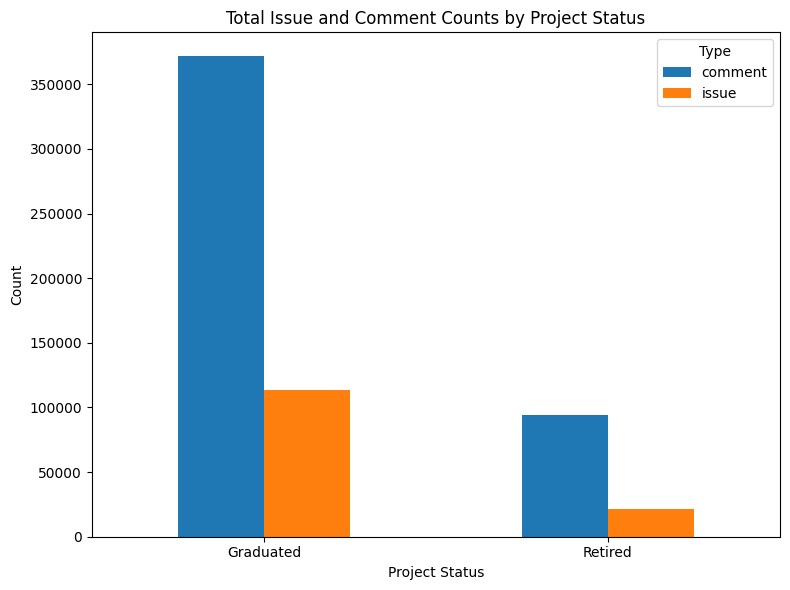

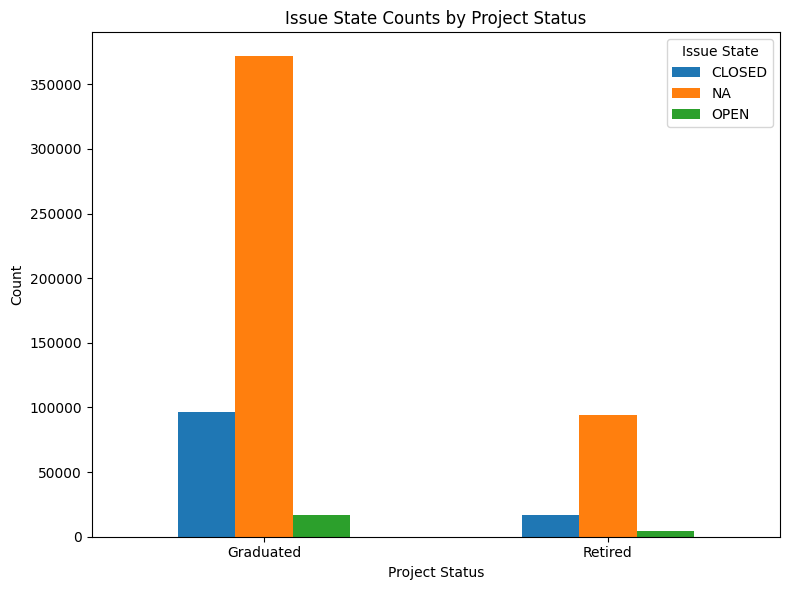

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_cleaned_data(folder):
    """Load all CSV files from the given folder and concatenate them into one DataFrame."""
    all_dfs = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path)
            all_dfs.append(df)
    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()

cleaned_folder = "issues-cleanedData"
df = load_cleaned_data(cleaned_folder)


# Plot 1: Count of Issues and Comments by Status

if "status" in df.columns and "type" in df.columns:
    # Group by status and type
    grouped_type = df.groupby(["status", "type"]).size().reset_index(name="count")
    pivot_type = grouped_type.pivot(index="status", columns="type", values="count").fillna(0)
    
    plt.figure(figsize=(8,6))
    pivot_type.plot(kind="bar", ax=plt.gca())
    plt.title("Total Issue and Comment Counts by Project Status")
    plt.xlabel("Project Status")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'status' and/or 'type' not found in the data for Plot 1.")

# Plot 2: Issue State Counts (Open, Closed, NA) by Status

if "status" in df.columns and "issue_state" in df.columns:
    df["issue_state_group"] = df["issue_state"].fillna("NA")
    grouped_state = df.groupby(["status", "issue_state_group"]).size().reset_index(name="count")
    pivot_state = grouped_state.pivot(index="status", columns="issue_state_group", values="count").fillna(0)
    
    plt.figure(figsize=(8,6))
    pivot_state.plot(kind="bar", ax=plt.gca())
    plt.title("Issue State Counts by Project Status")
    plt.xlabel("Project Status")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.legend(title="Issue State")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'status' and/or 'issue_state' not found in the data for Plot 2.")


# ML Model

In [ ]:
pip install tensorflow

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ---------------------------
# Hyperparameters
# ---------------------------
epochs = 10              # Number of epochs for training
batch_size = 16          # Batch size for training
learning_rate = 0.001    # Learning rate for Adam optimizer
weight_decay = 1e-4      # L2 regularization factor

# LSTM-specific hyperparameters:
lstm_units_layer1 = 128  # Units in first LSTM layer
lstm_units_layer2 = 64   # Units in second LSTM layer
dropout_rate = 0.2       # Dropout rate (and recurrent dropout) for LSTM layers

# ---------------------------
# Data Preparation
# ---------------------------
input_dir = "issues-cleanedData"  # Directory with cleaned CSV files

# Lists to hold each repository's sequence and label
sequences = []
labels = []

# Determine union of all categories for the 'issue_state' column across all files
issue_state_categories = set()
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
        # Remove rows where 'type' equals "comment"
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']
        if 'issue_state' in df.columns:
            unique_states = df['issue_state'].dropna().unique()
            issue_state_categories.update(unique_states)
issue_state_categories = sorted(list(issue_state_categories))

# Mapping for target labels: "graduated" is 1 and "retired" is 0
label_map = {"graduated": 1, "retired": 0}

# Process each CSV file (each representing one repository/sequence)
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue

        # Filter out rows where 'type' equals "comment"
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']

        # Ensure the required columns exist
        if not all(col in df.columns for col in ['issue_state', 'days_elapsed', 'status']):
            print(f"Skipping {filename}: required columns missing.")
            continue

        # Use the first value in the 'status' column as the label (convert to lowercase)
        repo_status = df['status'].iloc[0]
        repo_status = repo_status.lower() if isinstance(repo_status, str) else repo_status
        if repo_status not in label_map:
            print(f"Skipping {filename}: status value '{repo_status}' not in label_map.")
            continue

        # One-hot encode 'issue_state' (convert to integers for consistency)
        issue_state_dummies = pd.get_dummies(df['issue_state']).astype(int)
        issue_state_dummies = issue_state_dummies.reindex(columns=issue_state_categories, fill_value=0)

        # Process the 'days_elapsed' column: convert to float and normalize (e.g., divide by 1000)
        try:
            days_elapsed = (df['days_elapsed'].astype(float).to_frame()) / 1000.0
        except Exception as e:
            print(f"Error processing 'days_elapsed' in {filename}: {e}")
            continue

        # If available, process an additional feature: 'comments_count'
        if 'comments_count' in df.columns:
            try:
                comments_count = (df['comments_count'].astype(float).to_frame()) / 100.0
            except Exception as e:
                print(f"Error processing 'comments_count' in {filename}: {e}")
                # If conversion fails, use a column of zeros
                comments_count = pd.DataFrame(np.zeros((df.shape[0], 1)), columns=["comments_count"])
            # Combine all features
            features = pd.concat([issue_state_dummies, days_elapsed, comments_count], axis=1)
        else:
            features = pd.concat([issue_state_dummies, days_elapsed], axis=1)

        # Fill any missing values in features
        features = features.fillna(0)

        # Convert the features DataFrame to a NumPy array (each row is a timestep)
        seq = features.values
        if seq.shape[0] == 0:
            print(f"Skipping {filename}: no valid rows after filtering.")
            continue

        sequences.append(seq)
        labels.append(label_map[repo_status])

# Ensure we have at least one valid sequence
if not sequences:
    sys.exit("Error: No valid sequences found. Check CSV files for required columns and valid status values.")

# ---------------------------
# Sequence Padding
# ---------------------------
# Pad sequences so that they all have the same number of timesteps.
# A pad value of -999 is used (chosen to be unlikely to appear in the actual features)
max_timesteps = max(seq.shape[0] for seq in sequences)
X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', value=-999.0)
y = np.array(labels)

# Print summary of processed data
print("Processed Data Summary:")
print("Number of sequences:", len(sequences))
print("Shape of padded sequences (X):", X.shape)
print("Labels (y):", y)

# ---------------------------
# Train / Validation / Test Split (70/10/20)
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42, shuffle=True
)

# After splitting the data, check class distributions:
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Training label distribution:", dict(zip(unique_train, counts_train)))

unique_val, counts_val = np.unique(y_val, return_counts=True)
print("Validation label distribution:", dict(zip(unique_val, counts_val)))

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Test label distribution:", dict(zip(unique_test, counts_test)))

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ---------------------------
# Build the LSTM Model
# ---------------------------
num_features = X.shape[2]  # Number of features per timestep

model = Sequential()
# Add a Masking layer so that padded timesteps (value = -999) are ignored
model.add(Masking(mask_value=-999.0, input_shape=(max_timesteps, num_features)))

# First LSTM layer with 128 units, dropout and recurrent dropout, returning sequences (for stacking)
model.add(LSTM(lstm_units_layer1,
               dropout=dropout_rate,
               return_sequences=True,
               kernel_regularizer=l2(weight_decay)))

# Second LSTM layer with 64 units, dropout and recurrent dropout (outputs final hidden state)
model.add(LSTM(lstm_units_layer2,
               dropout=dropout_rate,
               kernel_regularizer=l2(weight_decay)))

# Final Dense layer for binary classification (graduated vs. retired)
model.add(Dense(1, activation='relu', kernel_regularizer=l2(weight_decay)))

# Compile the model using Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# ---------------------------
# Train the Model
# ---------------------------
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# ---------------------------
# Evaluate on Test Set and Print Confusion Matrix
# ---------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)


Processed Data Summary:
Number of sequences: 88
Shape of padded sequences (X): (88, 15520, 3)
Labels (y): [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 1 1]
Training label distribution: {np.int64(0): np.int64(21), np.int64(1): np.int64(40)}
Validation label distribution: {np.int64(0): np.int64(3), np.int64(1): np.int64(6)}
Test label distribution: {np.int64(0): np.int64(6), np.int64(1): np.int64(12)}
Train shape: (61, 15520, 3) (61,)
Validation shape: (9, 15520, 3) (9,)
Test shape: (18, 15520, 3) (18,)


c:\Users\sarik\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 15520, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15520, 128)     │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 149s 37s/step - accuracy: 0.3734 - loss: 4.0302 - val_accuracy: 0.3333 - val_loss: 0.7183
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 184s 49s/step - accuracy: 0.5834 - loss: 0.9910 - val_accuracy: 0.6667 - val_loss: 0.7812
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 238s 52s/step - accuracy: 0.5628 - loss: 1.3559 - val_accuracy: 0.6667 - val_loss: 0.7020
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 195s 49s/step - accuracy: 0.5587 - loss: 0.7518 - val_accuracy: 0.6667 - val_loss: 0.6670
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 218s 55s/step - accuracy: 0.5819 - loss: 0.7082 - val_accuracy: 0.6667 - val_loss: 0.6843
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 239s 60s/step - accuracy: 0.5676 - loss: 0.7971 - val_accuracy: 0.6667 - val_loss: 0.6874
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 253s 63s/step - accuracy: 0.5521 - loss: 0.7230 - val_accuracy: 0.6667 - val_loss: 0.6732
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 256s 63s/step - accuracy: 0.5652 - loss: 0.7181 - val_accuracy: 0.6667 - val_loss:

In [ ]:
pip install optuna; seaborn

^C
Note: you may need to restart the kernel to use updated packages.


c:\Users\sarik\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-06 14:04:15,137] A new study created in memory with name: no-name-e0108454-f65f-42be-bef9-96d740516e5c


Processed Data Summary:
Number of sequences: 88
Shape of padded sequences (X): (88, 27260, 3)
Labels (y): [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 1 1]


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_de

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.3190 - loss: 2.7826 - val_accuracy: 0.3333 - val_loss: 1.0311
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.4223 - loss: 0.8764 - val_accuracy: 0.5556 - val_loss: 0.6858
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.5122 - loss: 0.9184 - val_accuracy: 0.6667 - val_loss: 0.5019
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.6501 - loss: 1.2187 - val_accuracy: 0.6667 - val_loss: 0.5007
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 13s/step - accuracy: 0.6054 - loss: 1.3207 - val_accuracy: 0.6667 - val_loss: 0.5657
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 22s/step - accuracy: 0.6751 - loss: 0.8344 - val_accuracy: 0.7778 - val_loss: 0.6444
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 22s/step - accuracy: 0.5071 - loss: 0.7861 - val_accuracy: 0.4444 - val_loss: 0.7243
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.4511 - loss: 0.7722 - val_accuracy: 0.3333 - val_loss: 0.7757
Epoc

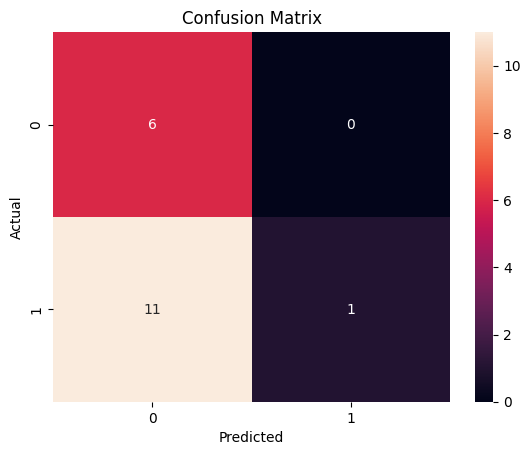

Best trial: 0. Best value: 0.751549:  10%|█         | 1/10 [10:19<1:32:54, 619.44s/it]C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[I 2025-03-06 14:14:34,566] Trial 0 finished with value: 0.751549243927002 and parameters: {'learning_rate': 0.0026999557468111667, 'dropout_rate': 0.21466847050360097, 'batch_size': 16, 'weight_decay': 8.660819491082323e-05, 'lstm_units': 32}. Best is trial 0 with value: 0.751549243927002.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 32s/step - accuracy: 0.4002 - loss: 4.6056 - val_accuracy: 0.3333 - val_loss: 1.5757
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 34s/step - accuracy: 0.3374 - loss: 1.1879 - val_accuracy: 0.3333 - val_loss: 1.0822
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 131s 33s/step - accuracy: 0.3359 - loss: 1.0561 - val_accuracy: 0.4444 - val_loss: 0.8117
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 136s 34s/step - accuracy: 0.5831 - loss: 0.7882 - val_accuracy: 0.6667 - val_loss: 0.6392
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 135s 34s/step - accuracy: 0.5628 - loss: 1.5648 - val_accuracy: 0.6667 - val_loss: 0.6555
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 36s/step - accuracy: 0.4804 - loss: 1

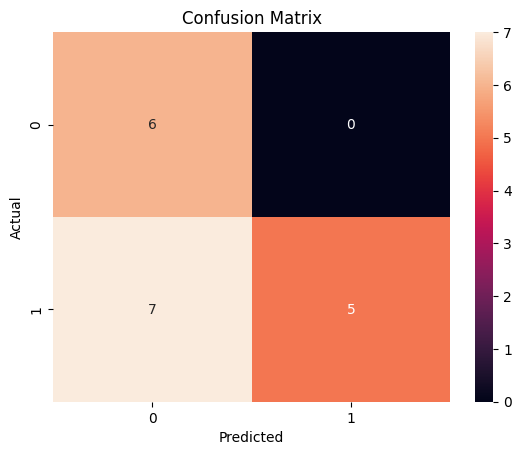

Best trial: 1. Best value: 0.63227:  20%|██        | 2/10 [33:31<2:23:10, 1073.78s/it]C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[I 2025-03-06 14:37:46,388] Trial 1 finished with value: 0.6322695016860962 and parameters: {'learning_rate': 0.001026397785736888, 'dropout_rate': 0.1591731536170976, 'batch_size': 16, 'weight_decay': 0.00021636898019335564, 'lstm_units': 64}. Best is trial 1 with value: 0.6322695016860962.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 167s 41s/step - accuracy: 0.3481 - loss: 2.8931 - val_accuracy: 0.3333 - val_loss: 2.0689
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 163s 41s/step - accuracy: 0.3231 - loss: 1.6733 - val_accuracy: 0.3333 - val_loss: 1.7840
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 160s 40s/step - accuracy: 0.4315 - loss: 1.4741 - val_accuracy: 0.3333 - val_loss: 1.6153
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 159s 40s/step - accuracy: 0.3752 - loss: 1.4150 - val_accuracy: 0.3333 - val_loss: 1.4929
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 160s 41s/step - accuracy: 0.3523 - loss: 1.2059 - val_accuracy: 0.3333 - val_loss: 1.3978
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 178s 47s/step - accuracy: 0.3502 - loss: 

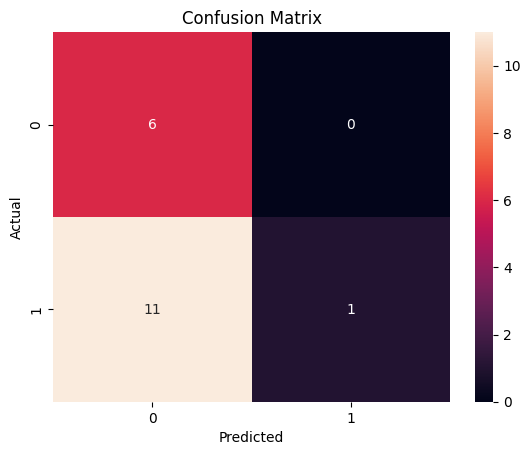

Best trial: 1. Best value: 0.63227:  30%|███       | 3/10 [1:00:57<2:35:46, 1335.28s/it]C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

[I 2025-03-06 15:05:12,841] Trial 2 finished with value: 1.0837092399597168 and parameters: {'learning_rate': 0.0002473472879813696, 'dropout_rate': 0.24296779353884745, 'batch_size': 16, 'weight_decay': 0.0005693676283593242, 'lstm_units': 64}. Best is trial 1 with value: 0.6322695016860962.
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 64s 64s/step - accuracy: 0.3443 - loss: 3.8385 - val_accuracy: 0.3333 - val_loss: 2.9432
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3443 - loss: 2.8170 - val_accuracy: 0.3333 - val_loss: 2.8763
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.3443 - loss: 2.5655 - val_accuracy: 0.3333 - val_loss: 2.8162
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.3443 - loss: 2.3852 - val_accuracy: 0.3333 - val_loss: 2.7621
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3443 - loss: 2.4432 - val_accuracy: 0.3333 - val_loss: 2.7134
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3443 - loss: 2.323

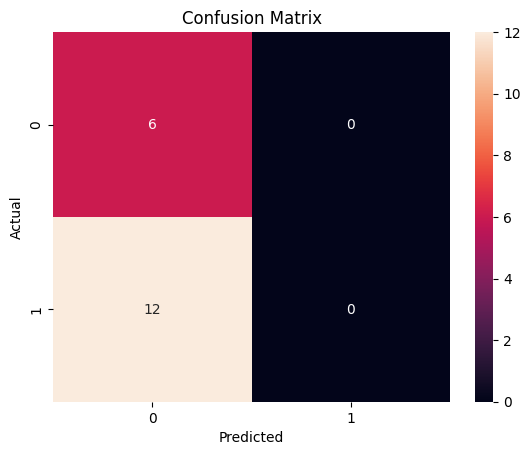

Best trial: 1. Best value: 0.63227:  30%|███       | 3/10 [1:05:12<2:35:46, 1335.28s/it]

[I 2025-03-06 15:09:27,710] Trial 3 finished with value: 2.5248916149139404 and parameters: {'learning_rate': 4.050517640821728e-05, 'dropout_rate': 0.3267291764393086, 'batch_size': 64, 'weight_decay': 8.412391441386732e-05, 'lstm_units': 32}. Best is trial 1 with value: 0.6322695016860962.


Best trial: 1. Best value: 0.63227:  40%|████      | 4/10 [1:05:12<1:30:52, 908.74s/it] 

Epoch 1/10


C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
c:\Users\sarik\AppDa

2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 37s/step - accuracy: 0.3649 - loss: 7.4447 - val_accuracy: 0.3333 - val_loss: 9.3657
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 37s/step - accuracy: 0.3441 - loss: 7.1302 - val_accuracy: 0.3333 - val_loss: 9.3606
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 35s/step - accuracy: 0.3337 - loss: 6.5884 - val_accuracy: 0.3333 - val_loss: 9.3565
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 38s/step - accuracy: 0.3441 - loss: 5.8899 - val_accuracy: 0.3333 - val_loss: 9.3512
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 66s 36s/step - accuracy: 0.3545 - loss: 5.9249 - val_accuracy: 0.3333 - val_loss: 9.3467
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 39s/step - accuracy: 0.3545 - loss: 6.1062 - val_accuracy: 0.3333 - val_loss: 9.3430
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 34s/step - accuracy: 0.3128 - loss: 5.2909 - val_accuracy: 0.3333 - val_loss: 9.3398
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 35s/step - accuracy: 0.3649 - loss: 6.2429 - val_accuracy: 0.3333 - val_loss: 9.3370
Epoch 9/10


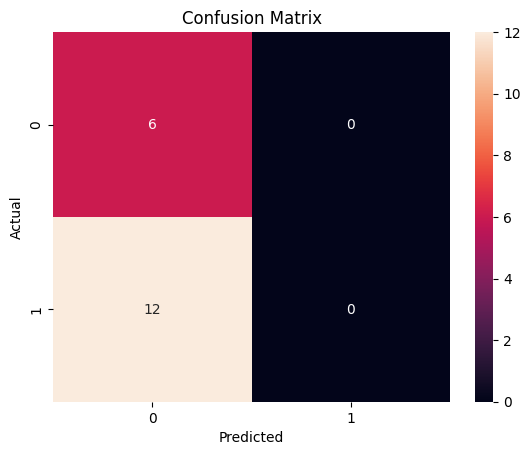

Best trial: 1. Best value: 0.63227:  50%|█████     | 5/10 [1:17:46<1:11:04, 852.83s/it]

[I 2025-03-06 15:22:01,405] Trial 4 finished with value: 9.332464218139648 and parameters: {'learning_rate': 7.906946475666033e-05, 'dropout_rate': 0.3991400977299121, 'batch_size': 32, 'weight_decay': 1.1575486438826055e-05, 'lstm_units': 64}. Best is trial 1 with value: 0.6322695016860962.
Epoch 1/10


C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
c:\Users\sarik\AppDa

2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 40s/step - accuracy: 0.3337 - loss: 7.3651 - val_accuracy: 0.3333 - val_loss: 9.3222
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 0.3858 - loss: 5.4753 - val_accuracy: 0.3333 - val_loss: 9.2653
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 95s 48s/step - accuracy: 0.3649 - loss: 5.2002 - val_accuracy: 0.3333 - val_loss: 9.2212
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 36s/step - accuracy: 0.3337 - loss: 5.6101 - val_accuracy: 0.3333 - val_loss: 9.1810
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 33s/step - accuracy: 0.3337 - loss: 5.6624 - val_accuracy: 0.3333 - val_loss: 7.7256
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 40s/step - accuracy: 0.3540 - loss: 4.5765 - val_accuracy: 0.3333 - val_loss: 2.9947
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 41s/step - accuracy: 0.3441 - loss: 1.9859 - val_accuracy: 0.3333 - val_loss: 0.9262
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 32s/step - accuracy: 0.3014 - loss: 0.7852 - val_accuracy: 0.7778 - val_loss: 0.6515
Epoch 9/10


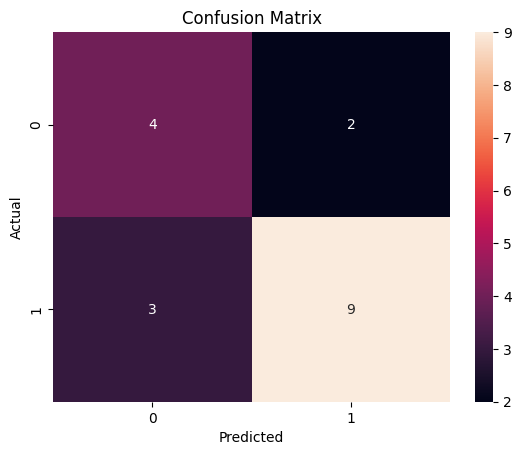

Best trial: 5. Best value: 0.599605:  60%|██████    | 6/10 [1:31:18<55:56, 839.03s/it]  

[I 2025-03-06 15:35:33,635] Trial 5 finished with value: 0.599605143070221 and parameters: {'learning_rate': 0.0012599862246722797, 'dropout_rate': 0.33870482833646165, 'batch_size': 32, 'weight_decay': 1.0871019612179402e-05, 'lstm_units': 64}. Best is trial 5 with value: 0.599605143070221.
Epoch 1/10


C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
c:\Users\sarik\AppDa

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.3443 - loss: 4.5605 - val_accuracy: 0.3333 - val_loss: 2.1023
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3443 - loss: 1.8962 - val_accuracy: 0.3333 - val_loss: 1.9502
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.3443 - loss: 1.9655 - val_accuracy: 0.3333 - val_loss: 1.8386
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.3443 - loss: 1.7033 - val_accuracy: 0.3333 - val_loss: 1.7483
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.3443 - loss: 1.6027 - val_accuracy: 0.3333 - val_loss: 1.6760
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.3443 - loss: 1.6484 - val_accuracy: 0.3333 - val_loss: 1.6182
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.3443 - loss: 1.4890 - val_accuracy: 0.3333 - val_loss: 1.5653
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.3443 - loss: 1.4342 - val_accuracy: 0.3333 - val_loss: 1.5167
Epoch 9/10


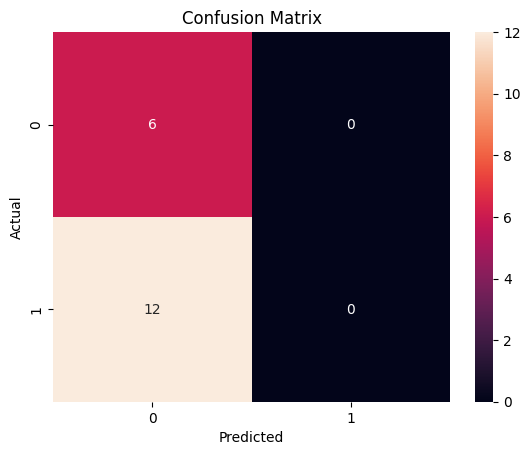

[I 2025-03-06 15:40:33,728] Trial 6 finished with value: 1.4642531871795654 and parameters: {'learning_rate': 0.0004995889463494875, 'dropout_rate': 0.4457258821432173, 'batch_size': 64, 'weight_decay': 4.6976527036324975e-05, 'lstm_units': 32}. Best is trial 5 with value: 0.599605143070221.

Best trial: 5. Best value: 0.599605:  70%|███████   | 7/10 [1:36:18<33:08, 662.84s/it]


Epoch 1/10


C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
c:\Users\sarik\AppDa

1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step - accuracy: 0.3443 - loss: 4.7673 - val_accuracy: 0.3333 - val_loss: 3.3987
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - accuracy: 0.3443 - loss: 2.7014 - val_accuracy: 0.3333 - val_loss: 3.0625
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - accuracy: 0.3443 - loss: 2.4512 - val_accuracy: 0.3333 - val_loss: 2.8680
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 0.3443 - loss: 2.5778 - val_accuracy: 0.3333 - val_loss: 2.7340
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 88s 88s/step - accuracy: 0.3443 - loss: 2.3564 - val_accuracy: 0.3333 - val_loss: 2.6294
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step - accuracy: 0.3443 - loss: 2.1076 - val_accuracy: 0.3333 - val_loss: 2.5428
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step - accuracy: 0.3443 - loss: 2.0486 - val_accuracy: 0.3333 - val_loss: 2.4697
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 97s 97s/step - accuracy: 0.3443 - loss: 2.2006 - val_accuracy: 0.3333 - val_loss: 2.4071
Epoch 9/1

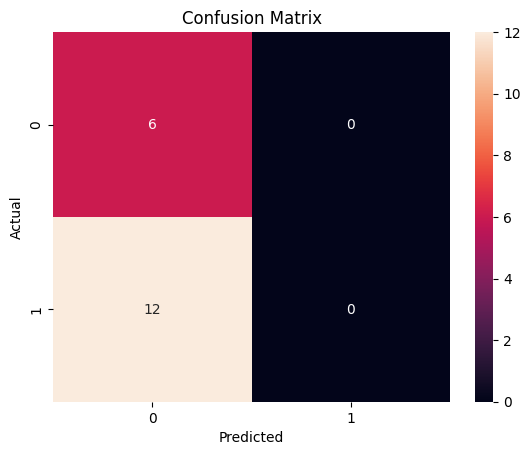

Best trial: 5. Best value: 0.599605:  70%|███████   | 7/10 [1:52:10<33:08, 662.84s/it]

[I 2025-03-06 15:56:25,367] Trial 7 finished with value: 2.303828001022339 and parameters: {'learning_rate': 0.00010540257152196981, 'dropout_rate': 0.37012073436845017, 'batch_size': 64, 'weight_decay': 9.478883650847481e-05, 'lstm_units': 64}. Best is trial 5 with value: 0.599605143070221.


Best trial: 5. Best value: 0.599605:  80%|████████  | 8/10 [1:52:10<25:09, 754.78s/it]

Epoch 1/10


C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
c:\Users\sarik\AppDa

1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.3443 - loss: 7.8776 - val_accuracy: 0.3333 - val_loss: 9.4622
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3443 - loss: 6.4717 - val_accuracy: 0.3333 - val_loss: 9.3908
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3443 - loss: 6.2434 - val_accuracy: 0.3333 - val_loss: 8.3269
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.3443 - loss: 6.5134 - val_accuracy: 0.3333 - val_loss: 8.0823
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.3443 - loss: 5.8781 - val_accuracy: 0.3333 - val_loss: 4.0347
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.3443 - loss: 3.1493 - val_accuracy: 0.3333 - val_loss: 2.2424
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.3443 - loss: 1.7778 - val_accuracy: 0.3333 - val_loss: 1.9232
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.3443 - loss: 1.4947 - val_accuracy: 0.3333 - val_loss: 1.7252
Epoch 9/10


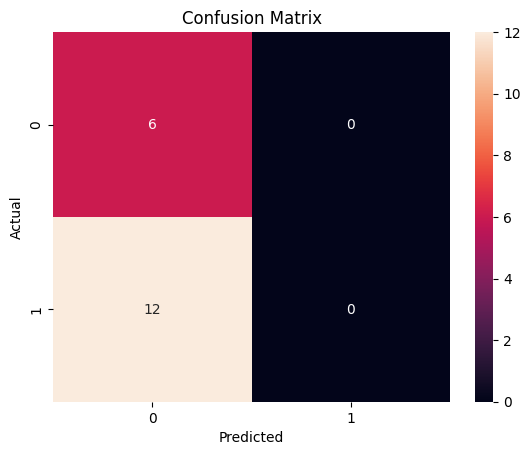

Best trial: 5. Best value: 0.599605:  90%|█████████ | 9/10 [1:59:06<10:48, 648.90s/it]

[I 2025-03-06 16:03:21,480] Trial 8 finished with value: 1.47298002243042 and parameters: {'learning_rate': 0.0012939809492505457, 'dropout_rate': 0.2146174980422062, 'batch_size': 64, 'weight_decay': 1.0932738185358375e-05, 'lstm_units': 32}. Best is trial 5 with value: 0.599605143070221.
Epoch 1/10


C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:126: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
C:\Users\sarik\AppData\Local\Temp\ipykernel_22320\4215273865.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
c:\Users\sarik\AppDa

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.3443 - loss: 7.8351 - val_accuracy: 0.3333 - val_loss: 9.3376
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.3443 - loss: 6.6804 - val_accuracy: 0.3333 - val_loss: 9.3351
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.3443 - loss: 6.6764 - val_accuracy: 0.3333 - val_loss: 9.3332
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.3443 - loss: 6.6968 - val_accuracy: 0.3333 - val_loss: 9.3313
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - accuracy: 0.3443 - loss: 6.5401 - val_accuracy: 0.3333 - val_loss: 9.3297
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.3443 - loss: 7.1651 - val_accuracy: 0.3333 - val_loss: 9.3283
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.3443 - loss: 6.9068 - val_accuracy: 0.3333 - val_loss: 9.3271
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.3443 - loss: 6.6138 - val_accuracy: 0.3333 - val_loss: 9.3260
Epoch 9/10


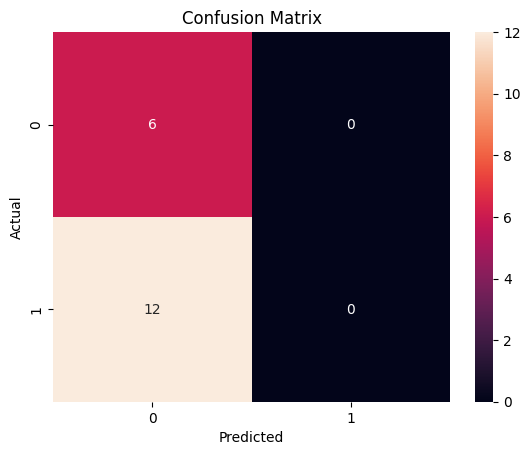

Best trial: 5. Best value: 0.599605:  90%|█████████ | 9/10 [2:05:45<10:48, 648.90s/it]

[I 2025-03-06 16:10:00,916] Trial 9 finished with value: 9.32402515411377 and parameters: {'learning_rate': 8.945374188416544e-05, 'dropout_rate': 0.21551779729490292, 'batch_size': 64, 'weight_decay': 0.00020495260682633422, 'lstm_units': 32}. Best is trial 5 with value: 0.599605143070221.


Best trial: 5. Best value: 0.599605: 100%|██████████| 10/10 [2:05:45<00:00, 754.58s/it]

Best hyperparameters:
{'learning_rate': 0.0012599862246722797, 'dropout_rate': 0.33870482833646165, 'batch_size': 32, 'weight_decay': 1.0871019612179402e-05, 'lstm_units': 64}
Best Test Accuracy: 0.7222222222222222


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import optuna

# ---------------------------
# Fixed Hyperparameters for Data Processing
# ---------------------------
epochs = 10  # Use the same number of epochs for each trial

# ---------------------------
# Data Preparation
# ---------------------------
input_dir = "issues-cleanedData"  # Directory with cleaned CSV files

# Lists to hold each repository's sequence and label
sequences = []
labels = []

# Determine union of all categories for the 'issue_state' column across all files
issue_state_categories = set()
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']
        if 'issue_state' in df.columns:
            unique_states = df['issue_state'].dropna().unique()
            issue_state_categories.update(unique_states)
issue_state_categories = sorted(list(issue_state_categories))

# Mapping for target labels: "graduated" is 1 and "retired" is 0
label_map = {"graduated": 1, "retired": 0}

# Process each CSV file (each representing one repository/sequence)
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']
        if not all(col in df.columns for col in ['issue_state', 'days_elapsed', 'status']):
            print(f"Skipping {filename}: required columns missing.")
            continue
        repo_status = df['status'].iloc[0]
        repo_status = repo_status.lower() if isinstance(repo_status, str) else repo_status
        if repo_status not in label_map:
            print(f"Skipping {filename}: status value '{repo_status}' not in label_map.")
            continue
        # One-hot encode 'issue_state'
        issue_state_dummies = pd.get_dummies(df['issue_state']).astype(int)
        issue_state_dummies = issue_state_dummies.reindex(columns=issue_state_categories, fill_value=0)
        # Normalize 'days_elapsed' using StandardScaler
        try:
            scaler = StandardScaler()
            days_elapsed_scaled = scaler.fit_transform(df[['days_elapsed']].astype(float))
            days_elapsed = pd.DataFrame(days_elapsed_scaled, columns=['days_elapsed'])
        except Exception as e:
            print(f"Error processing 'days_elapsed' in {filename}: {e}")
            continue
        # Combine features (only issue_state and days_elapsed)
        features = pd.concat([issue_state_dummies, days_elapsed], axis=1)
        features = features.fillna(0)
        seq = features.values
        if seq.shape[0] == 0:
            print(f"Skipping {filename}: no valid rows after filtering.")
            continue
        sequences.append(seq)
        labels.append(label_map[repo_status])

if not sequences:
    sys.exit("Error: No valid sequences found. Check CSV files for required columns and valid status values.")

# ---------------------------
# Sequence Padding
# ---------------------------
max_timesteps = max(seq.shape[0] for seq in sequences)
X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', value=-1.0)
y = np.array(labels)

print("Processed Data Summary:")
print("Number of sequences:", len(sequences))
print("Shape of padded sequences (X):", X.shape)
print("Labels (y):", y)

# Class Weights for Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ---------------------------
# Train / Validation / Test Split (70/10/20)
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42, shuffle=True
)

# ---------------------------
# Optuna Objective Function for Hyperparameter Tuning
# ---------------------------
def objective(trial):
    lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    bs = trial.suggest_categorical("batch_size", [16, 32, 64])
    wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    units = trial.suggest_categorical("lstm_units", [64, 32])

    model = Sequential()
    model.add(Masking(mask_value=-1.0, input_shape=(max_timesteps, X.shape[2])))
    model.add(LSTM(units, dropout=dr, kernel_regularizer=l2(wd)))
    model.add(Flatten())
    model.add(Dense(1, activation='relu', kernel_regularizer=l2(wd)))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=bs,
                        validation_data=(X_val, y_val),
                        class_weight=class_weight_dict,
                        verbose=1)

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
    acc = np.mean(y_pred == y_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Test Accuracy: {acc}")
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Store test accuracy in trial's user attributes
    trial.set_user_attr("test_acc", acc)

    return history.history['val_loss'][-1]

# ---------------------------
# Run Optuna Study with Status Bar
# ---------------------------
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10, show_progress_bar=True)

# print("Best hyperparameters:")
# print(study.best_params)
# best_acc = max(study.trials, key=lambda t: t.value).user_attrs.get("test_acc", None)
# print(f"Best Test Accuracy: {best_acc}")


# ---------------------------
# Run Optuna Study with Status Bar
# ---------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

print("Best hyperparameters:")
print(study.best_params)

# Corrected retrieval of best test accuracy
best_trial = study.best_trial
best_acc = best_trial.user_attrs.get("test_acc", None)

print(f"Best Test Accuracy: {best_acc}")
